In [1]:
#### important libraries
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [2]:
#### reading movies dataset
movies = pd.read_csv('../dataset/Boltzmann_Machines/ml-1m/movies.dat',sep = '::',
                    engine = 'python',header = None, encoding = 'latin-1',
                     names = ['movie_id','movie_name','movie_genre'])
movies.head()

,movie_id,movie_name,movie_genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
#### reading users dataset
users = pd.read_csv('../dataset/Boltzmann_Machines/ml-1m/users.dat',sep = '::',
                    engine = 'python',header = None, encoding = 'latin-1',
                     names = ['user_id','user_gender','user_age','job_id','zip_code'])
users.head()

,user_id,user_gender,user_age,job_id,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
#### reading ratings dataset
ratings = pd.read_csv('../dataset/Boltzmann_Machines/ml-1m/ratings.dat',sep = '::',
                    engine = 'python',header = None, encoding = 'latin-1',
                     names = ['user_id','movie_id','ratings','timestamps'])
ratings.head()

,user_id,movie_id,ratings,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
#### prepraring the training and test set
""" Here we will not split the data manually rather use the already splitted (80-20) ratio dataset 
in our 100k (smaller dataset for education purpose)."""

#### train
train1 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u1.base', delimiter = '\t')
train1 = np.array(train1, dtype = 'int64')

train2 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u2.base', delimiter = '\t')
train2 = np.array(train2, dtype = 'int64')

train3 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u3.base', delimiter = '\t')
train3 = np.array(train3, dtype = 'int64')

train4 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u4.base', delimiter = '\t')
train4 = np.array(train4, dtype = 'int64')

train5 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u5.base', delimiter = '\t')
train5 = np.array(train5, dtype = 'int64')

#### test
test1 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u1.test', delimiter = '\t')
test1 = np.array(test1, dtype = 'int64')

test2 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u2.test', delimiter = '\t')
test2 = np.array(test2, dtype = 'int64')

test3 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u3.test', delimiter = '\t')
test3 = np.array(test3, dtype = 'int64')

test4 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u4.test', delimiter = '\t')
test4 = np.array(test4, dtype = 'int64')

test5 = pd.read_csv('../dataset/Boltzmann_Machines/ml-100k/u5.test', delimiter = '\t')
test5 = np.array(test5, dtype = 'int64')


In [6]:
#### getting the number of users and movies from all split
nb_users = int(max(max(train1[:,0]),max(train2[:,0]),max(train3[:,0]),max(train4[:,0]),max(train5[:,0]),
                  max(test1[:,0]),max(test2[:,0]),max(test3[:,0]),max(test4[:,0]),max(test5[:,0])))

nb_movies = int(max(max(train1[:,1]),max(train2[:,1]),max(train3[:,1]),max(train4[:,1]),max(train5[:,1]),
                  max(test1[:,1]),max(test2[:,1]),max(test3[:,1]),max(test4[:,1]),max(test5[:,1])))

print('number of users: ',nb_users)
print('number of movies: ',nb_movies)

number of users:  943
number of movies:  1682


In [7]:
#### coverting the data into an array with users in lines and movies in columns (required by NN)
#### list of list where for each movie list will be a list of all users rating

def convert_tolist(data):
    new_data = []
    for users_id in range(1,nb_users+1):
        """using nb_user+1 to consider the upper bound of the range"""
        movie_ids = data[:,1][data[:,0] == users_id]
        """all the movies rated by the users into a list"""
        rating_ids = data[:,2][data[:,0] == users_id]
        """all the ratings for each movies by the users into a list"""
        ratings_list = np.zeros(nb_movies)
        ratings_list[movie_ids-1] = rating_ids
        """movie_ids -1 because movie_id start at 1 whereas the rating list's index start at 0"""
        new_data.append(list(ratings_list))
    return new_data

X_train1 = convert_tolist(train1)
X_train2 = convert_tolist(train2)
X_train3 = convert_tolist(train3)
X_train4 = convert_tolist(train4)
X_train5 = convert_tolist(train5)

X_test1 = convert_tolist(test1)
X_test2 = convert_tolist(test2)
X_test3 = convert_tolist(test3)
X_test4 = convert_tolist(test4)
X_test5 = convert_tolist(test5)

In [8]:
#### coverting the data into Torch tensors
X_train1 = torch.FloatTensor(X_train1)
X_train2 = torch.FloatTensor(X_train2)
X_train3 = torch.FloatTensor(X_train3)
X_train4 = torch.FloatTensor(X_train4)
X_train5 = torch.FloatTensor(X_train5)

X_test1 = torch.FloatTensor(X_test1)
X_test2 = torch.FloatTensor(X_test2)
X_test3 = torch.FloatTensor(X_test3)
X_test4 = torch.FloatTensor(X_test4)
X_test5 = torch.FloatTensor(X_test5)

In [9]:
"""Unlike RBM, here we are considering all the ratings type like 0-5 where 0 is no rating and 5 is highest rating"""

'Unlike RBM, here we are considering all the ratings type like 0-5 where 0 is no rating and 5 is highest rating'

In [10]:
# #### converting the ratings into binary ratings : Liked (1) and Not Liked (0)

# """ here we are considering all movies irrespective of whether the movie is rated or watched by the user or not.
# This refers to BM which try to predict or assign rating to the missing movies 
# (follow conceptual videos for detail) """

# """ because we are converting the ratings to binary, we will replace 0 with -1 to state missing
# we will replace 1 abd 2 as not liked and more than 2 as liked"""

# X_train1[X_train1 == 0] = -1
# X_train1[X_train1 == 1] = 0
# X_train1[X_train1 == 2] = 0
# X_train1[X_train1 >= 3] = 1

# X_train2[X_train2 == 0] = -1
# X_train2[X_train2 == 1] = 0
# X_train2[X_train2 == 2] = 0
# X_train2[X_train2 >= 3] = 1

# X_train3[X_train3 == 0] = -1
# X_train3[X_train3 == 1] = 0
# X_train3[X_train3 == 2] = 0
# X_train3[X_train3 >= 3] = 1

# X_train4[X_train4 == 0] = -1
# X_train4[X_train4 == 1] = 0
# X_train4[X_train4 == 2] = 0
# X_train4[X_train4 >= 3] = 1

# X_train5[X_train5 == 0] = -1
# X_train5[X_train5 == 1] = 0
# X_train5[X_train5 == 2] = 0
# X_train5[X_train5 >= 3] = 1

# X_test1[X_test1 == 0] = -1
# X_test1[X_test1 == 1] = 0
# X_test1[X_test1 == 2] = 0
# X_test1[X_test1 >= 3] = 1

# X_test2[X_test2 == 0] = -1
# X_test2[X_test2 == 1] = 0
# X_test2[X_test2 == 2] = 0
# X_test2[X_test1 >= 3] = 1

# X_test3[X_test3 == 0] = -1
# X_test3[X_test3 == 1] = 0
# X_test3[X_test3 == 2] = 0
# X_test3[X_test3 >= 3] = 1

# X_test4[X_test4 == 0] = -1
# X_test4[X_test4 == 1] = 0
# X_test4[X_test4 == 2] = 0
# X_test4[X_test4 >= 3] = 1

# X_test5[X_test5 == 0] = -1
# X_test5[X_test5 == 1] = 0
# X_test5[X_test5 == 2] = 0
# X_test5[X_test5 >= 3] = 1

In [11]:
#### Creating the architecture of the Neural Network

"""Creating a SAE (Stacked Auto Encoder) class. We will make this class a child class of nn. Module class 
so that we can use all the existing variables and functions of nn.Module. nn.Module is a module of torch libraries
which contains a lot of class."""
class SAE(nn.Module):
    def __init__(self, ):
        """calling super method let us access methods from a parent class from within a child class """
        super(SAE, self).__init__()
        """we are inheriting our first class from parent class nn.Module (first full connection)
        the class name is linear which takes 3 inputs: number of inputs(no. of movies in our case),
        number of hidden nodes(arbitary based in experiment). This represent the first input and hidden layer"""
        self.fc1 = nn.Linear(nb_movies, 20)
        """second stacked fully connected layer - input comes from first hidden layer so 20,
        second layer contains 10 neurons"""
        self.fc2 = nn.Linear(20, 10)
        """third stacked fully connected layer - input comes from second hidden layer so 10,
        third layer contains 20 neurons same as second layer (decoding dimension = endcoding dimension)"""
        self.fc3 = nn.Linear(10, 20)
        """final stacked fully connected layer - input comes from third hidden layer so 20,
        fourth layer output layer same as input layer (decoding dimension = endcoding dimension)"""
        self.fc4 = nn.Linear(20, nb_movies)
        """defining activation function - signmoid in our case"""
        self.activation = nn.Sigmoid()
        
    """here we will declare our forward propagation of input to output using the above functions"""
    def forward(self, x):
        """first encoding movement"""
        x = self.activation(self.fc1(x))
        """second encoding movement"""
        x = self.activation(self.fc2(x))
        """third movement decoding"""
        x = self.activation(self.fc3(x))  
        """ forth decoding movement - without activation function"""
        x = self.fc4(x)
        return x

In [12]:
#### objects creation

"""object of SAE class"""
sae = SAE()

"""object of loss function"""
criterion = nn.MSELoss()

"""object of optimizer - RMSprop - put all parameters of SAE class and learning rate (0.01 in our case)
and weight decay (0.5 in our case)"""
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

#### one dimension to 3d for pytorch
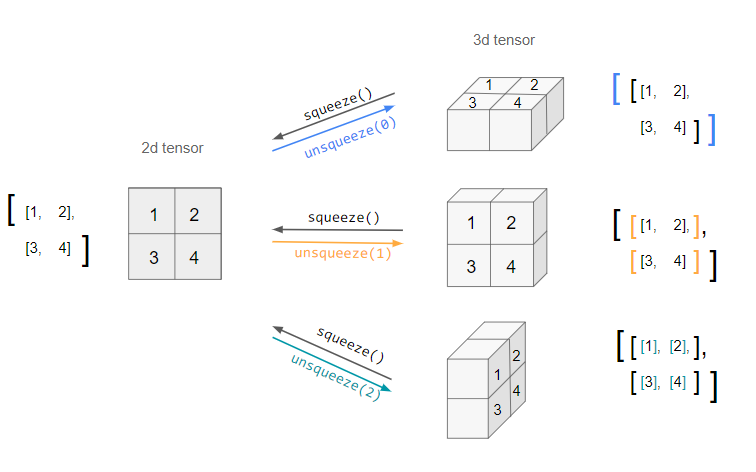

In [13]:
#### Training SAE

"""declaring number of epochs"""
nb_epochs = 100

"""training loop"""
for epoch in range(1,nb_epochs+1):
    """declaring training_loss and counter"""
    training_loss = 0
    count = 0.0
    """ we have to pass each users  for training"""
    for users_id in range(0,nb_users):
        """creating input - here we have to convert our one dimensional input into fake batch because pytorch 
        does not expect one dimension but batch learning. hence the steps"""
        input = Variable(X_train1[users_id]).unsqueeze(0)
        """creating target (clone of input for comparision)"""
        target = input.clone()
        """discarding any user who have no rating for any movie using conditional loop"""
        if torch.sum(target.data>0)>0:
            """prediction of input is done and stored in output for comparision"""
            output = sae.forward(input)
            """this. following line ensure that the target(which is replicant of input)
            does not follow gadient descent and hence takes less time to run (optimization)"""
            target.require_grad = False
            """the following code will ensure the output of users who haven't 
            rated any movies is 0(this helps to avoid uncessarily updating weights for such inputs)"""
            output[target ==0]=0
            """loss function"""
            loss = criterion(output, target)
            """creating a mean collector to mean the non zero ratings of the movies 
            (a small number is added at the end to ensure that the denominator is never 
            zero even if the sum is zer)"""
            mean_collector = nb_movies/float(torch.sum(target.data >0) + 1e-10)
            """loss backward propagation for weight updates - decide the direction of weight update"""
            loss.backward()
            """RMSE training loss  - loss*mean_collector to adjust"""
            training_loss += np.sqrt(loss.data*mean_collector)
            """count update"""
            count += 1
            """optimizer - decide the amount by which the weight would be updated"""
            optimizer.step()
    """printing each loss and train"""
    print('epoch: '+str(epoch)+' loss: '+str(training_loss/count))

epoch: 1 loss: tensor(1.7717)
epoch: 2 loss: tensor(1.0967)
epoch: 3 loss: tensor(1.0536)
epoch: 4 loss: tensor(1.0382)
epoch: 5 loss: tensor(1.0309)
epoch: 6 loss: tensor(1.0265)
epoch: 7 loss: tensor(1.0238)
epoch: 8 loss: tensor(1.0219)
epoch: 9 loss: tensor(1.0206)
epoch: 10 loss: tensor(1.0197)
epoch: 11 loss: tensor(1.0189)
epoch: 12 loss: tensor(1.0183)
epoch: 13 loss: tensor(1.0178)
epoch: 14 loss: tensor(1.0175)
epoch: 15 loss: tensor(1.0173)
epoch: 16 loss: tensor(1.0171)
epoch: 17 loss: tensor(1.0167)
epoch: 18 loss: tensor(1.0163)
epoch: 19 loss: tensor(1.0163)
epoch: 20 loss: tensor(1.0163)
epoch: 21 loss: tensor(1.0161)
epoch: 22 loss: tensor(1.0158)
epoch: 23 loss: tensor(1.0157)
epoch: 24 loss: tensor(1.0159)
epoch: 25 loss: tensor(1.0159)
epoch: 26 loss: tensor(1.0157)
epoch: 27 loss: tensor(1.0154)
epoch: 28 loss: tensor(1.0151)
epoch: 29 loss: tensor(1.0135)
epoch: 30 loss: tensor(1.0123)
epoch: 31 loss: tensor(1.0101)
epoch: 32 loss: tensor(1.0092)
epoch: 33 loss: t

In [14]:
#### Testing SAE

"""testing loop"""
"""declaring testing_loss and counter"""
testing_loss = 0
count = 0.0
""" we have to pass each users  for testing"""
for users_id in range(0,nb_users):
    """creating input - here we have to convert our one dimensional input into fake batch because pytorch 
    does not expect one dimension but batch learning. hence the steps"""
    """here for testing we will pass all ratings of the users in the training set so that it captures
    all the details and weight for available movies and then we will compare it with the prediction of test set"""
    input = Variable(X_train1[users_id]).unsqueeze(0)
    """as mentioned above, we will compare the prediction with real test set """
    target = Variable(X_test1[users_id]).unsqueeze(0)
    """discarding any user who have no rating for any movie using conditional loop"""
    if torch.sum(target.data>0)>0:
        """prediction of input is done and stored in output for comparision"""
        output = sae.forward(input)
        """this. following line ensure that the target(which is replicant of input)
        does not follow gadient descent and hence takes less time to run (optimization)"""
        target.require_grad = False
        """the following code will ensure the output of users who haven't 
        rated any movies is 0(this helps to avoid uncessarily updating weights for such inputs)"""
        output[target ==0]=0
        """loss function"""
        loss = criterion(output, target)
        """creating a mean collector to mean the non zero ratings of the movies 
        (a small number is added at the end to ensure that the denominator is never 
        zero even if the sum is zer)"""
        mean_collector = nb_movies/float(torch.sum(target.data >0) + 1e-10)
        """no loss backward for test set - no optimizer too"""
        """RMSE test loss  - loss*mean_collector to adjust"""
        testing_loss += np.sqrt(loss.data*mean_collector)
        """count update"""
        count += 1
"""printing each loss"""
print('test loss: '+str(training_loss/count))

test loss: tensor(1.9188)
